In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = (96, 96)

FEMALE = 0
MALE = 1
judges = ['Average', 'Beautiful']

### Face detector (Opencv)

In [3]:
import cv2

XML_PATH = cv2.data.haarcascades
facesCascade = cv2.CascadeClassifier(XML_PATH + '/haarcascade_frontalface_default.xml')

def detect_faces(image):
  coors = facesCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=6, minSize=(50, 50), flags=cv2.CASCADE_SCALE_IMAGE)
  faces = []
  for (x, y, w, h) in coors:
    face = image[y:y+w, x:x+h]
    face = cv2.resize(face, IMG_SIZE)
    faces.append(face)

  return coors, np.array(faces)

### Load models

In [4]:
gender_model = tf.keras.models.load_model('gender_2.h5')
beauty_model = tf.keras.models.load_model('beauty_1.h5')

In [5]:
def get_predicts(model, inputs):
  predictions = model.predict(inputs)
  predictions = tf.where(predictions >= 0.5, 1, 0).numpy().astype(np.int).flatten()
  return predictions

### Predict with images

No faces detected in img207.jpg


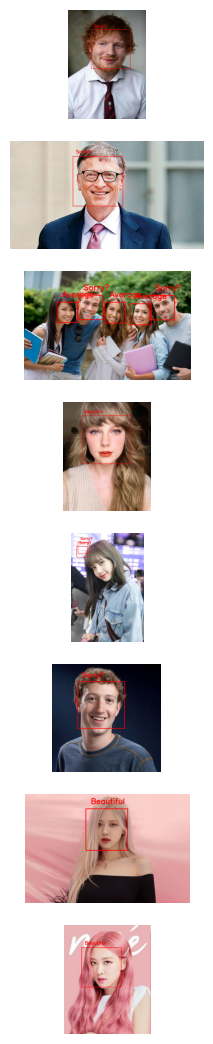

In [25]:
import os

TEST_PATH = './test img'

plt.figure(figsize=(15,15))

n = len(os.listdir(TEST_PATH))
count = 1
for file in os.listdir(TEST_PATH):
  image = cv2.imread(os.path.join(TEST_PATH, file))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  coors, faces = detect_faces(image)
  
  if (len(faces) == 0):
    print('No faces detected in ' + file)
    continue

  gender_predicts = get_predicts(gender_model, faces)
  beauty_predicts = get_predicts(beauty_model, faces)

  for idx, (x, y, w, h) in enumerate(coors):
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    if gender_predicts[idx] == MALE:
      text = "Sorry?"
    else:
      text = judges[beauty_predicts[idx]]
    cv2.putText(image, text, (x + 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

  plt.subplot(n,1,count)
  plt.imshow(image)
  plt.axis('off')
  count += 1

plt.show()

### Test with video/webcam

In [7]:
# cap = cv2.VideoCapture('test vid/vid.mp4')
cap = cv2.VideoCapture(0)
  
if cap.isOpened() == False:
  print('Error while opening the video')

while cap.isOpened():
  ret, frame = cap.read()
  if ret == False:
    print('Error while reading the video')
    break

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  coors, faces = detect_faces(image)
  
  if (len(faces) == 0):
    continue
  
  gender_predicts = get_predicts(gender_model, faces)
  beauty_predicts = get_predicts(beauty_model, faces)

  for idx, (x, y, w, h) in enumerate(coors):
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    if gender_predicts[idx] == MALE:
      text = "Sorry?"
    else:
      text = judges[beauty_predicts[idx]]
    cv2.putText(image, text, (x + 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  cv2.imshow('demo', image)
  if cv2.waitKey(25) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()